Hello, This is a notebook from a non datascientest user who is diving into the differential privacy stuff for the first time.

Now before we begin, let me make it clear that this notebook may contain the code that

- does not make any sense.
- uses the APIs in the wrong way.
- or lacks the basic understanding of the datascience concepts.

The approach taken in this notebook is to
- download a copy of the raw data
- perform some basic exploratory research on it.
- obtain the antigranular session.
- access the data in the `PrivateDataFrame`.
- try to perform the same operations on those `PrivateDataFrame`
- Try to visualize the output of those operations.

I hope this is useful to the new users like me.

Let's first get the raw data and do some exploration.
As described at https://www.antigranular.com/datasets/64abecde30b8344f8d168c0d.

The source for the given dataset can be found at https://archive.ics.uci.edu/dataset/2/adult, this link contains the description of the dataset.
The actual `.zip` file containgin the dataset can be found at https://archive.ics.uci.edu/static/public/2/adult.zip

Let's download it.

In [ ]:
!wget https://archive.ics.uci.edu/static/public/2/adult.zip

--2023-11-07 08:44:14--  https://archive.ics.uci.edu/static/public/2/adult.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.zip’

adult.zip               [  <=>               ] 605.70K  1.73MB/s    in 0.3s    

2023-11-07 08:44:14 (1.73 MB/s) - ‘adult.zip’ saved [620237]



Let's unzip it and see the contents of this zip file.

In [ ]:
!unzip adult.zip
!ls

Archive:  adult.zip
  inflating: Index                   
  inflating: adult.data              
  inflating: adult.names             
  inflating: adult.test              
  inflating: old.adult.names         
adult.data  adult.names  adult.test  adult.zip	Index  old.adult.names	sample_data


The contents are as follows
- adult.data
- adult.names
- adult.test
- adult.zip
- Index
- old.adult.names
- sample_data

out of these files, adult.data is the file that contains the data used in the dataset (for differential privacy).
let's see what is there in that file.

In [ ]:
! head adult.data

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, <=50K
52, Self-emp-not-inc, 209642, HS-grad, 9, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 45, United-States, >50K
31, 

This file lack the headers, lets add those, as mentioned at archive.ics.uci.edu, the columns are as follows:
- age
- workclass
- fnlwght
- education
- educational-num
- marital-status
- occupation
- relationship
- race
- sex
- capital-gain
- capital-loss
- hours-per-week
- native-country
- class

let's add the headers.

In [ ]:
!sed -i '1i age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class' adult.data

Let's check again the contents of `adult.data`

In [ ]:
!head adult.data

age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 

Now, it looks good, we can use python to start the analysis.

In [ ]:
import pandas as pd
pdf = pd.read_csv("adult.data")

In [ ]:
pdf

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [ ]:
pdf.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


there are some columns contianing string values, we need to make them int/float, something that can be used for analysis.

In [ ]:
enum_cols = {"workclass":{}, "education":{}, "marital-status":{}, "occupation":{}, "relationship":{}, "race":{}, "sex":{}, "native-country":{}, "class":{}}
normalized_cols = {}
def get_enum(df, column):
  return {j[1]: j[0] for j in enumerate([i.strip() for i in df[column].unique()])}

def make_enum(x, ref=None):
  if x.strip() in ref:
    return ref[x.strip()]
  else:
    return -1
for i in enum_cols:
  enum_cols[i] = get_enum(pdf, i)
  normalized_cols[i] = pdf[i].apply(make_enum, ref= enum_cols[i])
  pdf[i] = normalized_cols[i]


In [ ]:
pdf

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,0,77516,0,13,0,0,0,0,0,2174,0,40,0,0
1,50,1,83311,0,13,1,1,1,0,0,0,0,13,0,0
2,38,2,215646,1,9,2,2,0,0,0,0,0,40,0,0
3,53,2,234721,2,7,1,2,1,1,0,0,0,40,0,0
4,28,2,338409,0,13,1,3,2,1,1,0,0,40,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,2,257302,6,12,1,10,2,0,1,0,0,38,0,0
32557,40,2,154374,1,9,1,9,1,0,0,0,0,40,0,1
32558,58,2,151910,1,9,6,0,4,0,1,0,0,40,0,0
32559,22,2,201490,1,9,0,0,3,0,0,0,0,20,0,0


In [ ]:
pdf.describe()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
count,32561.000000,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,2.309972,1.897784e+05,3.424465,10.080679,1.083781,4.666411,1.542397,0.221707,0.330795,1077.648844,87.303830,40.437456,1.290317,0.240810
std,13.640433,1.225728,1.055500e+05,3.453582,2.572720,1.251381,3.386119,1.437431,0.627348,0.470506,7385.292085,402.960219,12.347429,5.045373,0.427581
min,17.000000,0.000000,1.228500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,2.000000,1.178270e+05,1.000000,9.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
50%,37.000000,2.000000,1.783560e+05,2.000000,10.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
75%,48.000000,2.000000,2.370510e+05,5.000000,12.000000,1.000000,7.000000,3.000000,0.000000,1.000000,0.000000,0.000000,45.000000,0.000000,0.000000
max,90.000000,8.000000,1.484705e+06,15.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,41.000000,1.000000


Since we now have all the values represented as int/float, lets visualize the data.

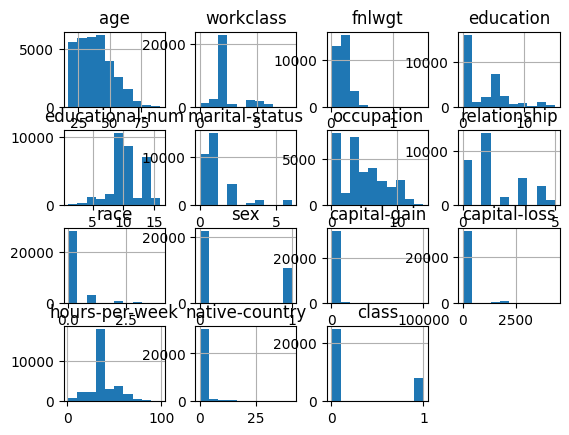

In [ ]:
hist = pdf.hist()

Just to have some clarity, let's plot some individual columns

{'Bachelors': 0, 'HS-grad': 1, '11th': 2, 'Masters': 3, '9th': 4, 'Some-college': 5, 'Assoc-acdm': 6, 'Assoc-voc': 7, '7th-8th': 8, 'Doctorate': 9, 'Prof-school': 10, '5th-6th': 11, '10th': 12, '1st-4th': 13, 'Preschool': 14, '12th': 15}
{'Male': 0, 'Female': 1}
{'Never-married': 0, 'Married-civ-spouse': 1, 'Divorced': 2, 'Married-spouse-absent': 3, 'Separated': 4, 'Married-AF-spouse': 5, 'Widowed': 6}


<Axes: >

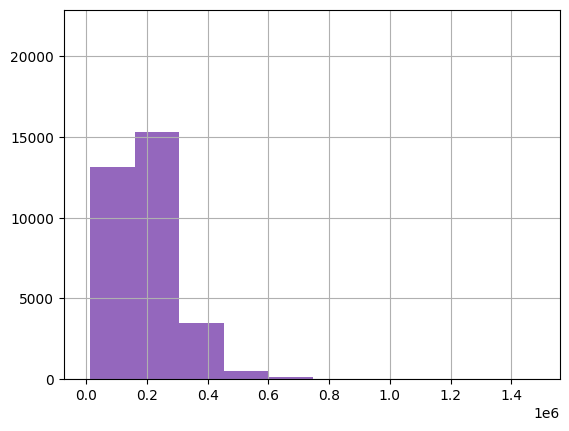

In [ ]:
pdf["age"].hist()
print(enum_cols["education"])
pdf["education"].hist()
print(enum_cols["sex"])
pdf["sex"].hist()
print(enum_cols["marital-status"])
pdf["marital-status"].hist()
pdf["fnlwgt"].hist()

Let's filter some data, for now I'll be filtering the data for the people between the age of 25 to 45.

In [ ]:
print(pdf["fnlwgt"])
age_25_45 = pdf.where(pdf["age"]>= 25)
age_25_45 = age_25_45.where(age_25_45["age"] <= 45)
age_25_45.describe()

0         77516
1         83311
2        215646
3        234721
4        338409
          ...  
32556    257302
32557    154374
32558    151910
32559    201490
32560    287927
Name: fnlwgt, Length: 32561, dtype: int64


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
count,17364.000000,17364.000000,1.736400e+04,17364.000000,17364.000000,17364.000000,17364.000000,17364.000000,17364.000000,17364.000000,17364.000000,17364.000000,17364.000000,17364.000000,17364.000000
mean,34.802695,2.207671,1.922505e+05,3.149044,10.384301,1.048606,4.507487,1.449896,0.244529,0.312774,944.805748,90.461645,42.821067,1.380039,0.254434
std,5.942195,1.104283,1.087400e+05,3.290993,2.454687,1.034257,3.262799,1.423214,0.660367,0.463636,6569.642432,406.174677,10.905766,5.181946,0.435555
min,25.000000,0.000000,1.228500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,30.000000,2.000000,1.179630e+05,1.000000,9.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
50%,35.000000,2.000000,1.809220e+05,1.000000,10.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
75%,40.000000,2.000000,2.408410e+05,5.000000,13.000000,1.000000,6.000000,2.000000,0.000000,1.000000,0.000000,0.000000,48.000000,0.000000,1.000000
max,45.000000,8.000000,1.484705e+06,15.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,3900.000000,99.000000,41.000000,1.000000


filtering the data people from high earning class who are in the age range 25-45

In [ ]:
high_earning_class = age_25_45.where(age_25_45["class"] == 1)

Let's plot it.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'workclass'}>,
        <Axes: title={'center': 'fnlwgt'}>,
        <Axes: title={'center': 'education'}>],
       [<Axes: title={'center': 'educational-num'}>,
        <Axes: title={'center': 'marital-status'}>,
        <Axes: title={'center': 'occupation'}>,
        <Axes: title={'center': 'relationship'}>],
       [<Axes: title={'center': 'race'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'capital-gain'}>,
        <Axes: title={'center': 'capital-loss'}>],
       [<Axes: title={'center': 'hours-per-week'}>,
        <Axes: title={'center': 'native-country'}>,
        <Axes: title={'center': 'class'}>, <Axes: >]], dtype=object)

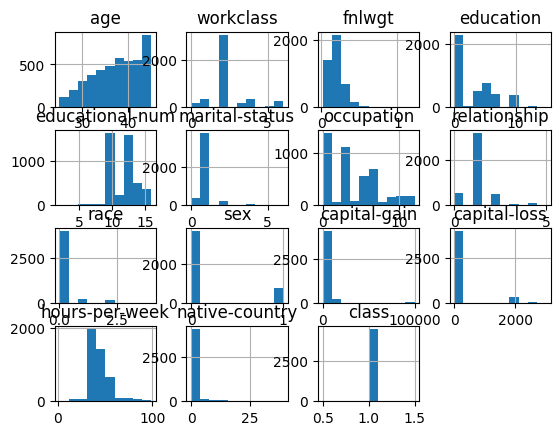

In [ ]:
high_earning_class.hist()

{'State-gov': 0, 'Self-emp-not-inc': 1, 'Private': 2, 'Federal-gov': 3, 'Local-gov': 4, '?': 5, 'Self-emp-inc': 6, 'Without-pay': 7, 'Never-worked': 8}


<Axes: >

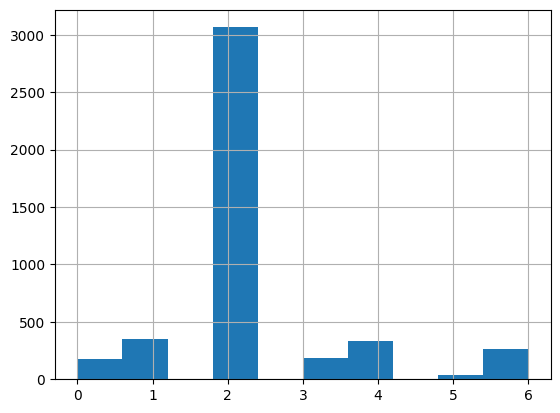

In [ ]:
print(enum_cols["workclass"])
high_earning_class["workclass"].hist()

This shows us that most people from the high income class are the employees of a private company.

In the next step let's try to do the same exploration with antigranular and find out what is the difference between the regular python and `Private Python`
and what we can and can not do with it.

## Install antigranular package

In [ ]:
!pip install antigranular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.5 MB/s eta 0:00:00


Log in to antigranular and create the python session.

In [ ]:
import antigranular as ag
session = ag.login("<user-id>", "<user-secret>", dataset = "Adult Population Dataset")

Loading dataset "Adult Population Dataset" to the kernel...
Dataset "Adult Population Dataset" loaded to the kernel as adult_population_dataset
Connected to Antigranular server session id: 186ee6b5-3c93-41db-857e-a4f23bd077b0, the session will time out if idle for 60 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


As per the documentation the main difference here is that the complete data is not available as a single dataframe, but it's divided into three
- train_x
- train_y
- test_x

Also these are not `pandas.DataFrame` these are `PrivateDataFrame`s from antigranular.

let's see what we can and can't do with these.

In [ ]:
%%ag
# import the required packages.
# Got it from the docs and notebooks that are already hosted on the platform.
import numpy as np
import op_pandas as opd
from op_pandas import PrivateDataFrame
from ag_utils import export, load_dataset
import pandas as pd

# get the dataset
apd = adult_population_dataset
train_x = apd["train_x"]
train_y = apd["train_y"]
test_x = apd["test_x"]

Let's see what does the `train_x` `PrivateDataFrame` look like?


In [ ]:
%%ag
print(train_x)

Exception: Please use 'ag_print' instead of 'print'.


/usr/local/lib/python3.10/site-packages/RestrictedPython/compile.py:206: SyntaxWarning: Line None: Prints, but never reads 'printed' variable.
  warnings.warn(



We can't print anything in the antigranular env, we need to export it

In [ ]:
%%ag
export(train_x, "train_x")

An exception occurred: Please ensure export function is called on a non-private type.

ValueError: Please ensure export function is called on a non-private type.


We can't export the dataframe itself, we can call the differentially private functions for them and export the output.

In [ ]:
%%ag
export(train_x.describe(eps=0.005) , 'train_x_desc')

Setting up exported variable in local environment: train_x_desc


In [ ]:
train_x_desc

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,31039.000000,3.103900e+04,31039.000000,31039.000000,31039.000000,31039.000000
mean,30.044368,7.132660e+04,11.444183,36353.246714,0.000000,1.000000
std,24.485734,7.304842e+05,4.765680,7451.372454,2017.029098,29.267833
min,17.000000,1.859232e+04,1.000000,60798.254406,255.241094,1.000000
25%,27.252787,1.537730e+04,11.777047,30996.353184,1719.495813,14.297706
50%,31.772206,1.917881e+05,6.773079,30725.993784,2819.154884,40.930745
75%,62.214811,6.978315e+05,11.531455,87077.698993,2419.223691,18.337886
max,33.519091,1.132625e+06,14.223222,31434.635126,3688.534648,72.976470


We can see that (as the name suggests it's the trainig data) the data contains 51318 rows, which is much less than the original dataset.

Now let's try to pull down some data from individual columns.

In [ ]:
%%ag
x = train_x["age"].describe(eps=0.0001)

In [ ]:
%%ag
export(x, "x")

Setting up exported variable in local environment: x


In [ ]:
x

count    130828.000000
mean         19.094364
std          32.589931
min          17.000000
25%          53.638380
50%          18.361117
75%          86.827880
max          67.865280
Name: series, dtype: float64

In [ ]:
type(x)

pandas.core.series.Series

After exporting, we get a regular `pandas.Series` and we can also plot it.

<Axes: >

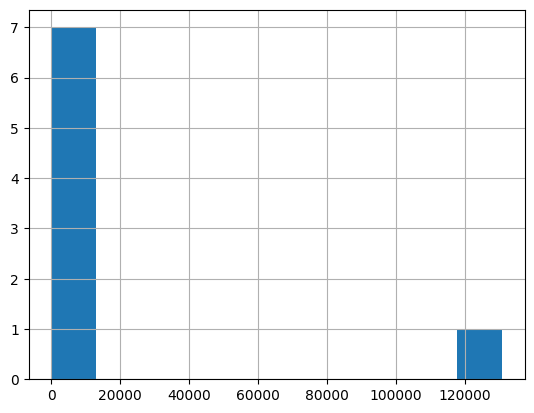

In [ ]:
x.hist()

This data contains the strings like the raw dataset. Need to represent those values in int/float like we did it before. Let's try to resue the code to do that.

In [ ]:
%%ag
enum_cols = {"workclass":{}, "education":{}, "marital-status":{}, "occupation":{}, "relationship":{}, "race":{}, "sex":{}, "native-country":{}, "class":{}}
normalized_cols = {}
def get_enum(df, column):
  return {j[1]: j[0] for j in enumerate([i.strip() for i in df[column].unique()])}

def make_enum(x, ref=None):
  if x.strip() in ref:
    return ref[x.strip()]
  else:
    return -1
for i in enum_cols:
  enum_cols[i] = get_enum(train_x, i)
  normalized_cols[i] = train_x[i].apply(make_enum, ref= enum_cols[i])
  train_x[i] = normalized_cols[i]


NameError: name 'enumerate' is not defined


There are three issues with this python code when we try to execute it in the antigranular env.

- `enumerate` is not allowed in the antigranular environment.
- `PrivateDataFrame` does not have a function equivalent to `DataFrame.apply`.
- there is also a difference between `DataFrame.applymap` and `PrivateDataFrame.applymap`.

So let's implement a longer version of the same code to do it.

In [ ]:
%%ag
# just copied the dict from the code above just to see the possible values for each column
cols_for_normalization = {'workclass': {'State-gov': 0,
  'Self-emp-not-inc': 1,
  'Private': 2,
  'Federal-gov': 3,
  'Local-gov': 4,
  '?': 5,
  'Self-emp-inc': 6,
  'Without-pay': 7,
  'Never-worked': 8},
 'education': {'Bachelors': 0,
  'HS-grad': 1,
  '11th': 2,
  'Masters': 3,
  '9th': 4,
  'Some-college': 5,
  'Assoc-acdm': 6,
  'Assoc-voc': 7,
  '7th-8th': 8,
  'Doctorate': 9,
  'Prof-school': 10,
  '5th-6th': 11,
  '10th': 12,
  '1st-4th': 13,
  'Preschool': 14,
  '12th': 15},
 'marital-status': {'Never-married': 0,
  'Married-civ-spouse': 1,
  'Divorced': 2,
  'Married-spouse-absent': 3,
  'Separated': 4,
  'Married-AF-spouse': 5,
  'Widowed': 6},
 'occupation': {'Adm-clerical': 0,
  'Exec-managerial': 1,
  'Handlers-cleaners': 2,
  'Prof-specialty': 3,
  'Other-service': 4,
  'Sales': 5,
  'Craft-repair': 6,
  'Transport-moving': 7,
  'Farming-fishing': 8,
  'Machine-op-inspct': 9,
  'Tech-support': 10,
  '?': 11,
  'Protective-serv': 12,
  'Armed-Forces': 13,
  'Priv-house-serv': 14},
 'relationship': {'Not-in-family': 0,
  'Husband': 1,
  'Wife': 2,
  'Own-child': 3,
  'Unmarried': 4,
  'Other-relative': 5},
 'race': {'White': 0,
  'Black': 1,
  'Asian-Pac-Islander': 2,
  'Amer-Indian-Eskimo': 3,
  'Other': 4},
 'sex': {'Male': 0, 'Female': 1},
 'native-country': {'United-States': 0,
  'Cuba': 1,
  'Jamaica': 2,
  'India': 3,
  '?': 4,
  'Mexico': 5,
  'South': 6,
  'Puerto-Rico': 7,
  'Honduras': 8,
  'England': 9,
  'Canada': 10,
  'Germany': 11,
  'Iran': 12,
  'Philippines': 13,
  'Italy': 14,
  'Poland': 15,
  'Columbia': 16,
  'Cambodia': 17,
  'Thailand': 18,
  'Ecuador': 19,
  'Laos': 20,
  'Taiwan': 21,
  'Haiti': 22,
  'Portugal': 23,
  'Dominican-Republic': 24,
  'El-Salvador': 25,
  'France': 26,
  'Guatemala': 27,
  'China': 28,
  'Japan': 29,
  'Yugoslavia': 30,
  'Peru': 31,
  'Outlying-US(Guam-USVI-etc)': 32,
  'Scotland': 33,
  'Trinadad&Tobago': 34,
  'Greece': 35,
  'Nicaragua': 36,
  'Vietnam': 37,
  'Hong': 38,
  'Ireland': 39,
  'Hungary': 40,
  'Holand-Netherlands': 41},
 'class': {'<=50K': 0, '>50K': 1}}


There is one more catch, we can have only one argument to the function when we use it for `PrivateDataFrame.applymap`

In [ ]:
%%ag
# from typing import Any
def normalize_workclass(x:str)->int:
  ref_dict = {'State-gov': 0,
  'Self-emp-not-inc': 1,
  'Private': 2,
  'Federal-gov': 3,
  'Local-gov': 4,
  '?': 5,
  'Self-emp-inc': 6,
  'Without-pay': 7,
  'Never-worked': 8}

  if x in ref_dict:
    return ref_dict[x]
  else:
    return -1

def normalize_education(x:str)->int:
  ref_dict = {'Bachelors': 0,
  'HS-grad': 1,
  '11th': 2,
  'Masters': 3,
  '9th': 4,
  'Some-college': 5,
  'Assoc-acdm': 6,
  'Assoc-voc': 7,
  '7th-8th': 8,
  'Doctorate': 9,
  'Prof-school': 10,
  '5th-6th': 11,
  '10th': 12,
  '1st-4th': 13,
  'Preschool': 14,
  '12th': 15}
  if x in ref_dict:
    return ref_dict[x]
  else:
    return -1

def normalize_marital_status(x:str)->int:
  ref_dict = {'Never-married': 0,
  'Married-civ-spouse': 1,
  'Divorced': 2,
  'Married-spouse-absent': 3,
  'Separated': 4,
  'Married-AF-spouse': 5,
  'Widowed': 6}
  if x in ref_dict:
    return ref_dict[x]
  else:
    return -1

def normalize_occupation(x:str)->int:
  ref_dict = {'Adm-clerical': 0,
  'Exec-managerial': 1,
  'Handlers-cleaners': 2,
  'Prof-specialty': 3,
  'Other-service': 4,
  'Sales': 5,
  'Craft-repair': 6,
  'Transport-moving': 7,
  'Farming-fishing': 8,
  'Machine-op-inspct': 9,
  'Tech-support': 10,
  '?': 11,
  'Protective-serv': 12,
  'Armed-Forces': 13,
  'Priv-house-serv': 14}
  if x in ref_dict:
    return ref_dict[x]
  else:
    return -1

def normalize_sex(x:str)->int:
  ref_dict = {'Male': 0, 'Female': 1}
  if x in ref_dict:
    return ref_dict[x]
  else:
    return -1

def normalize_country(x:str)->int:
  ref_dict = {'United-States': 0,
  'Cuba': 1,
  'Jamaica': 2,
  'India': 3,
  '?': 4,
  'Mexico': 5,
  'South': 6,
  'Puerto-Rico': 7,
  'Honduras': 8,
  'England': 9,
  'Canada': 10,
  'Germany': 11,
  'Iran': 12,
  'Philippines': 13,
  'Italy': 14,
  'Poland': 15,
  'Columbia': 16,
  'Cambodia': 17,
  'Thailand': 18,
  'Ecuador': 19,
  'Laos': 20,
  'Taiwan': 21,
  'Haiti': 22,
  'Portugal': 23,
  'Dominican-Republic': 24,
  'El-Salvador': 25,
  'France': 26,
  'Guatemala': 27,
  'China': 28,
  'Japan': 29,
  'Yugoslavia': 30,
  'Peru': 31,
  'Outlying-US(Guam-USVI-etc)': 32,
  'Scotland': 33,
  'Trinadad&Tobago': 34,
  'Greece': 35,
  'Nicaragua': 36,
  'Vietnam': 37,
  'Hong': 38,
  'Ireland': 39,
  'Hungary': 40,
  'Holand-Netherlands': 41}
  if x in ref_dict:
    return ref_dict[x]
  else:
    return -1

def normalize_class(x:str)->int:
  ref_dict = {'<=50K': 0, '>50K': 1}
  if x in ref_dict:
    return ref_dict[x]
  else:
    return -1

normalized_col_workclass = train_x.applymap(normalize_workclass, eps=0.01, output_bounds={'workclass':(0, 8)})
normalized_col_education = train_x.applymap(normalize_education, eps=0.01, output_bounds={'education':(0, 15)})
normalized_col_marital_status = train_x.applymap(normalize_marital_status, eps=0.01, output_bounds={'marital-status':(0, 6)})
normalized_col_occupation = train_x.applymap(normalize_occupation, eps=0.01, output_bounds={'occupation':(0, 14)})

In [ ]:
%%ag
normalized_col_sex = train_x.applymap(normalize_sex, eps=0.01, output_bounds={'sex':(0, 2)})

ValueError:  Column sex does not exist


turns out that the column `sex` is not present in the dataset in antigranular.

In [ ]:
%%ag
normalized_col_country = train_x.applymap(normalize_country, eps=0.01, output_bounds={'native-country':(0, 40)})
normalized_col_class = train_x.applymap(normalize_class, eps=0.01, output_bounds={'class':(0, 2)})

ValueError:  Column class does not exist


turns out that the column `class` is not present in the dataset in antigranular.

In [ ]:
%%ag
temp_x = train_x[["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]]
temp_x["workclass"] = normalized_col_workclass["workclass"]
temp_x["education"] = normalized_col_education["education"]
temp_x["marital-status"] = normalized_col_education["marital-status"]
temp_x["occupation"] = normalized_col_education["occupation"]
temp_x["native-country"] = normalized_col_education["native-country"]


/code/dependencies/op_pandas/op_pandas/core/private_dataframe.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._df[col].clip(lower=self._metadata[col][0], upper=self._metadata[col][1], inplace=True)
/code/dependencies/op_pandas/op_pandas/core/private_dataframe.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[key] = value._series
/code/dependencies/op_pandas/op_pandas/core/private_dataframe.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

In [ ]:
%%ag
export(str(temp_x.describe(eps=0.0001)), "tempx_cols")

ZeroDivisionError: float division by zero


In [ ]:
%%ag
normalized_col_workclass_y = train_x.applymap(normalize_workclass, eps=0.01, output_bounds={'workclass':(0, 8)})
normalized_col_education_y = train_x.applymap(normalize_education, eps=0.01, output_bounds={'education':(0, 15)})
normalized_col_marital_status_y = train_x.applymap(normalize_marital_status, eps=0.01, output_bounds={'marital-status':(0, 6)})
normalized_col_occupation_y = train_x.applymap(normalize_occupation, eps=0.01, output_bounds={'occupation':(0, 14)})
normalized_col_country_y = train_x.applymap(normalize_country, eps=0.01, output_bounds={'native-country':(0, 40)})


In [ ]:
%%ag
export(str(train_y.columns), "cols_y")

Setting up exported variable in local environment: cols_


I'll try to create a new Dataframe from theese normalized columns. Since the data came from a `PrivateDataFrame` the new DtaFrame also needs to be a `PrivateDataFrame`.

In [ ]:
%%ag

temp_y = train_y[["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]]
temp_y["workclass"] = normalized_col_workclass_y["workclass"]
temp_y["education"] = normalized_col_education_y["education"]
temp_y["marital-status"] = normalized_col_education_y["marital-status"]
temp_y["occupation"] = normalized_col_education_y["occupation"]
temp_y["native-country"] = normalized_col_education_y["native-country"]

KeyError: "None of [Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',\n       'hours-per-week'],\n      dtype='object')] are in the [columns]"


In [ ]:
%%ag
export(str(train_x.columns), "cols_x")

In [ ]:
cols

As it is we can't do any exploratory analysis on `PrivateDataFrame`, we can use `diffprivlib` a differentially private version of `scikitlearn` that provide the APIs for it.

In [ ]:
%%ag
import op_diffprivlib
from op_diffprivlib.models import RandomForestClassifier
l_meta, r_meta = [], []
for l,r in train_x.metadata.values():
  l_meta.append(l)
  r_meta.append(r)
bounds = ( l_meta , r_meta ) # ([lower] , [upper])
model = RandomForestClassifier(n_estimators=100, epsilon = 1.0 , random_state=0 , bounds=bounds, classes=["cat1", "cat2", "cat3"])


In [ ]:
%%ag
model.fit(temp_x,train_y)

ValueError: lower and upper bounds must have 11 element(s), got 6.


/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



In [ ]:
%%ag
workclass_hist = temp_x.hist(eps=0.0001, column="workclass")

In [ ]:
%%ag
export(workclass_hist, "workclass_hist")

Setting up exported variable in local environment: workclass_hist


In [ ]:
workclass_hist

(array([ 1030,  9421, 13960, 20768,  3873,     0, 18268,  7509,  1763,
            0]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]))

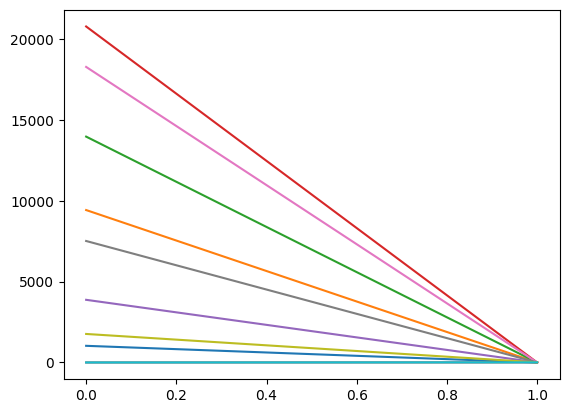

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
pd_ = pd.DataFrame(workclass_hist)
plt.plot(pd_)